In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchtune.modules import RotaryPositionalEmbeddings
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader

In [7]:
data = np.load(r"D:\Praharsha\code\CAMZ\data\interim\boundingboxes_array.npy", allow_pickle=True)
rows_to_remove = [443, 474]
data = np.delete(data, rows_to_remove, axis=0)
mask = np.array([np.any(video == None) for video in data])  # Identify rows with None
data = data[~mask]
data = data.astype(np.float32)
data.shape
mean = data.mean(axis=(0, 1), keepdims=True)
std = data.std(axis=(0, 1), keepdims=True)
data = (data - mean) / std
labels_df = pd.read_csv(r"D:\Praharsha\code\CAMZ\data\interim\verdict.csv")  # Adjust delimiter if needed
print(labels_df.head())

verdict = labels_df['Verdict']
verdicts = verdict[~mask]
print(verdicts.shape)

   Name  Inactivity score  Time_bottom score  Time_top score  \
0  1L.1                 0                  1               1   
1  1L.2                 0                  1               1   
2  1L.3                 0                  1               1   
3  1L.4                 0                  1               1   
4  1L.5                 0                  0               1   

   Large_angle score  Small_angle score  Final Score  Verdict  
0                  1                  0         0.50        1  
1                  1                  0         0.50        1  
2                  1                  1         0.70        1  
3                  0                  1         0.50        1  
4                  1                  1         0.55        1  
(586,)


In [8]:
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim=2, seq_len=300, latent_dim=64, num_heads=4, ff_dim=512, num_layers=4):
        super(TransformerAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.head_dim = latent_dim // num_heads

        # Input projection
        self.input_proj = nn.Linear(input_dim, latent_dim)
        self.pos_encoding = RotaryPositionalEmbeddings(dim=self.head_dim)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=latent_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.encoder_norm = nn.LayerNorm(latent_dim)
        # Latent vector via pooling
        self.latent_pool = nn.AdaptiveAvgPool1d(1)
        
        self.projection_head = nn.Sequential(
        nn.Linear(latent_dim, latent_dim),
        nn.ReLU(),
        nn.Linear(latent_dim, latent_dim)
        )


    def apply_rope(self, x):
        # x: (B, S, D)
        B, S, D = x.shape
        x = x.view(B, S, self.num_heads, self.head_dim)   # (B, S, N_H, H_D)
        x = self.pos_encoding(x)                          # Apply RoPE
        x = x.view(B, S, D)                               # Back to (B, S, D)
        return x
    
    def add_noise(self, x, noise_std=0.01):
        return x + noise_std * torch.randn_like(x)

    def rotate(self, x, angle_range=(-15, 15)):
        angle = torch.empty(1).uniform_(*angle_range).item()
        rad = torch.deg2rad(torch.tensor(angle))
        rotation_matrix = torch.tensor([
            [torch.cos(rad), -torch.sin(rad)],
            [torch.sin(rad),  torch.cos(rad)]
        ], device=x.device)
        return torch.matmul(x, rotation_matrix)
    
    def augment(self, x):
        if torch.rand(1).item() < 0.5:
            x = self.add_noise(x)
        else:
            x = self.rotate(x)
        return x

    def forward(self, x, apply_aug=True):
        if apply_aug:
            x = self.augment(x)  # Apply noise or rotation only if True

        x = self.input_proj(x)  # (B, S, latent_dim)
        x = self.apply_rope(x)
        x = self.encoder_norm(self.encoder(x))
        x_pooled = self.latent_pool(x.permute(0, 2, 1)).squeeze(-1)
        z = self.projection_head(x_pooled)
        z = nn.functional.normalize(z, dim=1)

        return z


In [11]:
def load_checkpoint(checkpoint, architecture, optimizer):
    
    checkpoint = torch.load(checkpoint)
    model = architecture()
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print("loaded checkpoint...")
    return model.eval()


model = TransformerAutoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

save_model_checkpoint_path = r"D:\Praharsha\code\CAMZ\models\model_history\5.0-Transformer\transformer.pth.tar"
model = load_checkpoint(save_model_checkpoint_path, TransformerAutoencoder, optimizer)

loaded checkpoint...


In [34]:
data = torch.tensor(data, dtype=torch.float32)
# Create DataLoaders
batch_size = 32
data_loader = DataLoader(data, batch_size=batch_size, shuffle=False)

C:\Users\USER\AppData\Local\Temp\ipykernel_21800\1563761897.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)


In [35]:
def extract_latents(model, data_loader, device='cpu'):
    model.eval()
    latents = []
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            z = model(batch)
            latents.append(z)
    return torch.cat(latents, dim=0)

latents = extract_latents(model, data_loader, device='cpu')

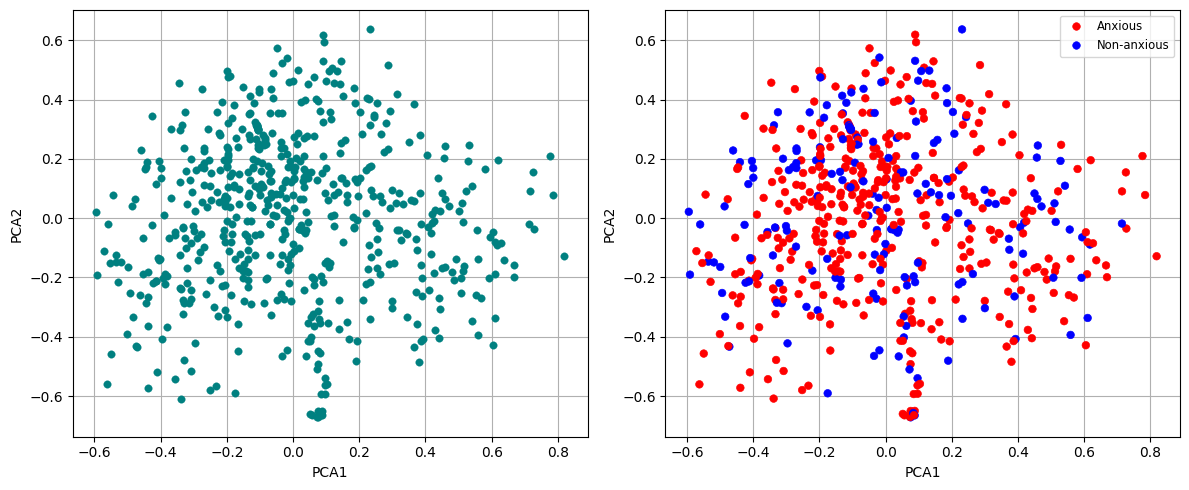

In [36]:
pca = PCA(n_components=2)
pca_latents = pca.fit_transform(latents)

df = pd.DataFrame(pca_latents, columns=['PCA1', 'PCA2'])
label_map = {0: 'Non-anxious', 1: 'Anxious'}
df['Label'] = [label_map[int(l)] for l in verdicts]

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PCA without labels
sns.scatterplot(data=df, x='PCA1', y='PCA2', ax=axes[0], s=30, edgecolor=None, color='teal', linewidth=0.2)
axes[0].set_axisbelow(True)
axes[0].grid(True)

# PCA with labels
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Label', palette={'Non-anxious':'blue', 'Anxious':'red'}, ax=axes[1], s=30, edgecolor=None)
axes[1].legend(loc='best', fontsize='small')
axes[1].set_axisbelow(True)
axes[1].grid(True)

plt.tight_layout()
plt.show()


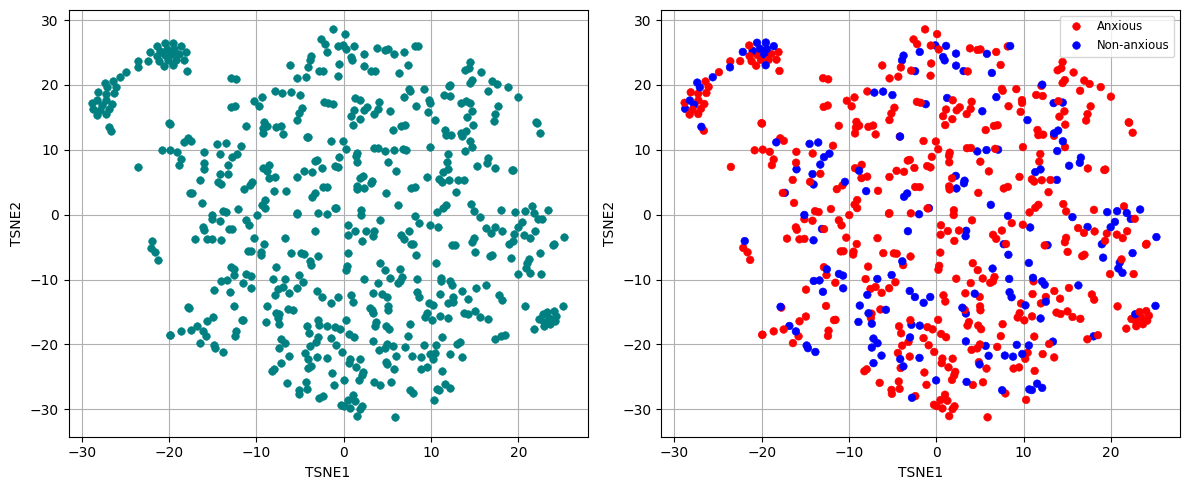

In [37]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_latents = tsne.fit_transform(latents)  # `latents` shape: (N, latent_dim)

# Step 2: Create DataFrame with custom label names
label_map = {0: 'Non-anxious', 1: 'Anxious'}
df_tsne = pd.DataFrame(tsne_latents, columns=['TSNE1', 'TSNE2'])
df_tsne['Label'] = [label_map[int(l)] for l in verdicts]

# Step 4: Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: t-SNE without labels
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', ax=axes[0], color='teal', s=30, edgecolor=None)
axes[0].grid(True)
axes[0].set_axisbelow(True)

# Right: t-SNE with labels
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Label', palette={'Non-anxious':'blue', 'Anxious':'red'}, ax=axes[1], s=30,edgecolor=None)
axes[1].legend(loc='best', fontsize='small')
axes[1].grid(True)
axes[1].set_axisbelow(True)

plt.tight_layout()
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_21800\3447188468.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(selected_data, dtype=torch.float32).to('cpu')


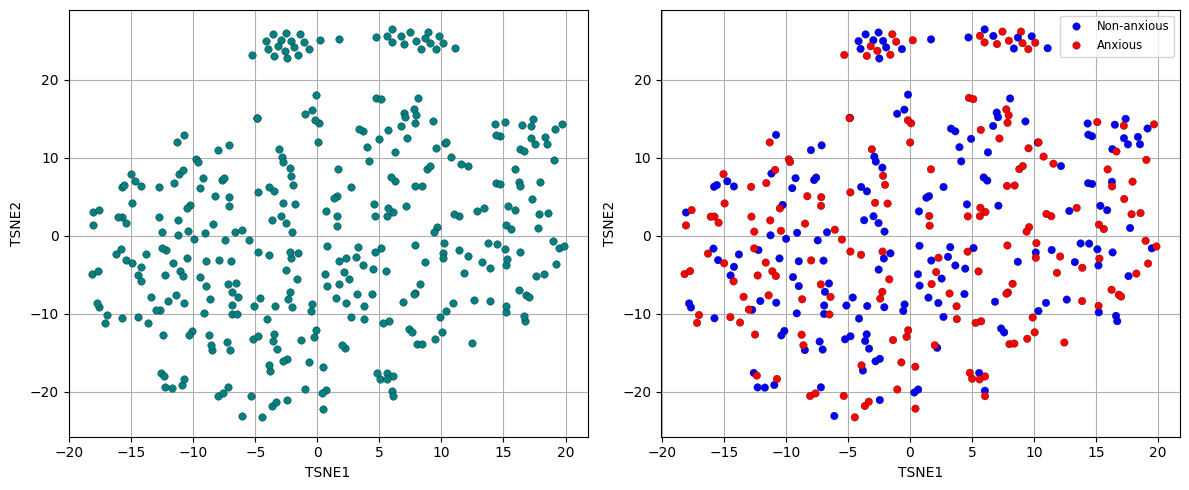

In [38]:

n_samples = 179

class_0_indices = np.where(np.array(verdicts) == 0)[0]
class_1_indices = np.where(np.array(verdicts) == 1)[0]

np.random.seed(42)
sampled_0 = np.random.choice(class_0_indices, n_samples, replace=False)
sampled_1 = np.random.choice(class_1_indices, n_samples, replace=False)

selected_indices = np.concatenate([sampled_0, sampled_1])
selected_labels = np.array(verdicts)[selected_indices]
selected_data = data[selected_indices]

# Model inference
x_tensor = torch.tensor(selected_data, dtype=torch.float32).to('cpu')
model.eval()
with torch.no_grad():
    selected_latents = model(x_tensor).cpu().numpy()

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_selected = tsne.fit_transform(selected_latents)

label_map = {0: 'Non-anxious', 1: 'Anxious'}
label_names = [label_map[int(l)] for l in selected_labels]
df_tsne = pd.DataFrame(tsne_selected, columns=['TSNE1', 'TSNE2'])
df_tsne['Label'] = label_names

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: t-SNE without labels
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', ax=axes[0], color='teal', s=30, edgecolor='black', linewidth=0.2)
axes[0].grid(True)
axes[0].set_axisbelow(True)

# Right: t-SNE with labels
palette = {'Non-anxious': 'blue', 'Anxious': 'red'}
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Label', palette=palette, ax=axes[1], s=30, edgecolor='black', linewidth=0.2)
axes[1].legend(loc='best', fontsize='small')
axes[1].grid(True)
axes[1].set_axisbelow(True)

plt.tight_layout()
plt.show()
